<a href="https://colab.research.google.com/github/shumshersubashgautam/Quantum-Reinforcement-Learning/blob/main/Quantum_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ZhengtongYan/QRL.git

Cloning into 'QRL'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 154 (delta 71), reused 110 (delta 36), pack-reused 0
Receiving objects: 100% (154/154), 4.44 MiB | 18.85 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [5]:
cd QRL

/content/QRL


In [6]:
cd 2-QNNDeepQLearning 

/content/QRL/2-QNNDeepQLearning


In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import TwoLocal

# Qiskit imports
import qiskit as qk
from qiskit.utils import QuantumInstance

# Qiskit Machine Learning imports
import qiskit_machine_learning as qkml
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

# PyTorch imports
import torch
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import LBFGS, SGD, Adam, RMSprop

# OpenAI Gym import
import gym

# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

# To get smooth animations on Jupyter Notebooks. 
# Note: these plotting function are taken from https://github.com/ageron/handson-ml2
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [8]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 

In [10]:
!pip install qiskit-machine-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 KB 13.2 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [2]:
def encoding_circuit(inputs, num_qubits = 4, *args):
    """
    Encode classical input data (i.e. the state of the enironment) on a quantum circuit. 
    To be used inside the `parametrized_circuit` function. 
    
    Args
    -------
    inputs (list): a list containing the classical inputs.
    num_qubits (int): number of qubits in the quantum circuit.
    
    Return
    -------
    qc (QuantumCircuit): quantum circuit with encoding gates.
    
    """
    
    qc = qk.QuantumCircuit(num_qubits)
    
    # Encode data with a RX rotation
    for i in range(len(inputs)): 
        qc.rx(inputs[i], i)
        
    return qc

def parametrized_circuit(num_qubits = 4, reuploading = False, reps = 2, insert_barriers = True, meas = False):
    """
    Create the Parameterized Quantum Circuit (PQC) for estimating Q-values.
    It implements the architecure proposed in Skolik et al. arXiv:2104.15084.
    
    Args
    -------
    num_qubit (int): number of qubits in the quantum circuit. 
    reuploading (bool): True if want to use data reuploading technique.
    reps (int): number of repetitions (layers) in the variational circuit. 
    insert_barrirerd (bool): True to add barriers in between gates, for better drawing of the circuit. 
    meas (bool): True to add final measurements on the qubits. 
    
    Return
    -------
    qc (QuantumCircuit): the full parametrized quantum circuit. 
    """
    
    qr = qk.QuantumRegister(num_qubits, 'qr')
    qc = qk.QuantumCircuit(qr)
    
    if meas:
        qr = qk.QuantumRegister(num_qubits, 'qr')
        cr = qk.ClassicalRegister(num_qubits, 'cr')
        qc = qk.QuantumCircuit(qr,cr)
    
    
    if not reuploading:
        
        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)
                
        # Encode classical input data
        qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Variational circuit
        qc.compose(TwoLocal(num_qubits, ['ry', 'rz'], 'cz', 'circular', 
               reps=reps, insert_barriers= insert_barriers, 
               skip_final_rotation_layer = True), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Add final measurements
        if meas: qc.measure(qr,cr)
        
    elif reuploading:
        
        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)
                
        # Define a vector containng variational parameters
        θ = qk.circuit.ParameterVector('θ', 2 * num_qubits * reps)
        
        # Iterate for a number of repetitions
        for rep in range(reps):

            # Encode classical input data
            qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
            if insert_barriers: qc.barrier()
                
            # Variational circuit (does the same as TwoLocal from Qiskit)
            for qubit in range(num_qubits):
                qc.ry(θ[qubit + 2*num_qubits*(rep)], qubit)
                qc.rz(θ[qubit + 2*num_qubits*(rep) + num_qubits], qubit)
            if insert_barriers: qc.barrier()
                
            # Add entanglers (this code is for a circular entangler)
            qc.cz(qr[-1], qr[0])
            for qubit in range(num_qubits-1):
                qc.cz(qr[qubit], qr[qubit+1])
            if insert_barriers: qc.barrier()
                        
        # Add final measurements
        if meas: qc.measure(qr,cr)
        
    return qc

In [3]:
# Select the number of qubits
num_qubits = 4

# Generate the Parametrized Quantum Circuit (note the flags reuploading and reps)
qc = parametrized_circuit(num_qubits = num_qubits, 
                          reuploading = True, 
                          reps = 6)

# Fetch the parameters from the circuit and divide them in Inputs (X) and Trainable Parameters (params)
# The first four parameters are for the inputs 
X = list(qc.parameters)[: num_qubits]

# The remaining ones are the trainable weights of the quantum neural network
params = list(qc.parameters)[num_qubits:]

qc.draw()

┌──────────┐ ░ ┌──────────┐┌──────────┐ ░              ░ ┌──────────┐ ░ »
qr_0: ┤ Rx(x[0]) ├─░─┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │  │        ░ ├──────────┤ ░ »
qr_1: ┤ Rx(x[1]) ├─░─┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │     │     ░ ├──────────┤ ░ »
qr_2: ┤ Rx(x[2]) ├─░─┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │        │  ░ ├──────────┤ ░ »
qr_3: ┤ Rx(x[3]) ├─░─┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─»
      └──────────┘ ░ └──────────┘└──────────┘ ░              ░ └──────────┘ ░ »
«       ┌──────────┐┌───────────┐ ░              ░ ┌──────────┐ ░ ┌───────────┐»
«qr_0: ─┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[16]) ├»
«       ├──────────┤├───────────┤ ░  │  │        ░ ├──────────┤ ░ ├───────────┤»
«qr_1: ─┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[17]) ├»
«      ┌┴──────────┤├───────────┤ ░  │     │     ░ ├──────────┤ ░ ├───────────┤»
«qr_2: ┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[18]) ├»
«      ├───────────┤├───────────┤ ░  │        │  ░ ├──────────┤ ░ ├───────────┤»
«qr_3: ┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[19]) ├»
«      └───────────┘└───────────┘ ░              ░ └──────────┘ ░ └───────────┘»
«      ┌───────────┐ ░              ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐»
«qr_0: ┤ Rz(θ[20]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[24]) ├┤ Rz(θ[28]) ├»
«      ├───────────┤ ░  │  │        ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_1: ┤ Rz(θ[21]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[25]) ├┤ Rz(θ[29]) ├»
«      ├───────────┤ ░  │     │     ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_2: ┤ Rz(θ[22]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[26]) ├┤ Rz(θ[30]) ├»
«      ├───────────┤ ░  │        │  ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_3: ┤ Rz(θ[23]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[27]) ├┤ Rz(θ[31]) ├»
«      └───────────┘ ░              ░ └──────────┘ ░ └───────────┘└───────────┘»
«       ░              ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐ ░          »
«qr_0: ─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[32]) ├┤ Rz(θ[36]) ├─░──■──■────»
«       ░  │  │        ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │  │    »
«qr_1: ─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[33]) ├┤ Rz(θ[37]) ├─░──┼──■──■─»
«       ░  │     │     ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │     │ »
«qr_2: ─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[34]) ├┤ Rz(θ[38]) ├─░──┼─────■─»
«       ░  │        │  ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │       »
«qr_3: ─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[35]) ├┤ Rz(θ[39]) ├─░──■───────»
«       ░              ░ └──────────┘ ░ └───────────┘└───────────┘ ░          »
«          ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐ ░              ░ 
«qr_0: ────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[40]) ├┤ Rz(θ[44]) ├─░──■──■────────░─
«          ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │  │        ░ 
«qr_1: ────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[41]) ├┤ Rz(θ[45]) ├─░──┼──■──■─────░─
«          ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │     │     ░ 
«qr_2: ─■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[42]) ├┤ Rz(θ[46]) ├─░──┼─────■──■──░─
«       │  ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │        │  ░ 
«qr_3: ─■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[43]) ├┤ Rz(θ[47]) ├─░──■────────■──░─
«          ░ └──────────┘ ░ └───────────┘└───────────┘ ░              ░

In [4]:
# Select a quantum backend to run the simulation of the quantum circuit
qi = QuantumInstance(qk.Aer.get_backend('statevector_simulator'))

# Create a Quantum Neural Network object starting from the quantum circuit defined above
qnn = CircuitQNN(qc, input_params=X, weight_params=params, 
                 quantum_instance = qi)

# Connect to PyTorch
initial_weights = (2*np.random.rand(qnn.num_weights) - 1)
quantum_nn = TorchConnector(qnn, initial_weights)

/usr/local/lib/python3.8/dist-packages/qiskit/utils/backend_utils.py:126: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  if has_ibmq():


In [5]:
class encoding_layer(torch.nn.Module):
    def __init__(self, num_qubits = 4):
        super().__init__()
        
        # Define weights for the layer
        weights = torch.Tensor(num_qubits)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, -1, 1) # <--  Initialization strategy
    
        
    def forward(self, x):
        """Forward step, as explained above."""
        
        if not isinstance(x, Tensor):
            x = Tensor(x)
        
        x = self.weights * x
        x = torch.atan(x)
                
        return x

In [6]:
class exp_val_layer(torch.nn.Module):
    def __init__(self, action_space = 2):
        super().__init__()
        
        # Define the weights for the layer
        weights = torch.Tensor(action_space)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, 35, 40) # <-- Initialization strategy (heuristic choice)
        
        # Masks that map the vector of probabilities to <Z_0*Z_1> and <Z_2*Z_3>
        self.mask_ZZ_12 = torch.tensor([1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.], requires_grad = False)
        self.mask_ZZ_34 = torch.tensor([-1.,-1.,-1.,-1.,1.,1.,1.,1.,-1.,-1.,-1.,-1.,1.,1.,1.,1.], requires_grad = False)
        
    def forward(self, x):
        """Forward step, as described above."""
        
        expval_ZZ_12 = self.mask_ZZ_12 * x
        expval_ZZ_34 = self.mask_ZZ_34 * x
        
        # Single sample
        if len(x.shape) == 1:
            expval_ZZ_12 = torch.sum(expval_ZZ_12)
            expval_ZZ_34 = torch.sum(expval_ZZ_34)
            out = torch.cat((expval_ZZ_12.unsqueeze(0), expval_ZZ_34.unsqueeze(0)))
        
        # Batch of samples
        else:
            expval_ZZ_12 = torch.sum(expval_ZZ_12, dim = 1, keepdim = True)
            expval_ZZ_34 = torch.sum(expval_ZZ_34, dim = 1, keepdim = True)
            out = torch.cat((expval_ZZ_12, expval_ZZ_34), 1)
                
        return self.weights * ((out + 1.) / 2.)

In [7]:
# Classical trainable preprocessing
encoding = encoding_layer()

# Classical trainable postprocessing
exp_val = exp_val_layer()

# Stack the classical and quantum layers together 
model = torch.nn.Sequential(encoding, 
                            quantum_nn, 
                            exp_val)

model.state_dict()

OrderedDict([('0.weights', tensor([ 0.7645,  0.8300, -0.2343,  0.9186])),
             ('1.weight',
              tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880, -0.8838,  0.7324,
                       0.2022,  0.4161, -0.9588,  0.9398,  0.6649, -0.5753, -0.6364, -0.6332,
                      -0.3915,  0.0495, -0.1361, -0.4175,  0.2237, -0.7210, -0.4157, -0.2673,
                      -0.0879,  0.5704, -0.6007,  0.0285,  0.1848, -0.9071,  0.2151, -0.6590,
                      -0.8699,  0.8978,  0.9313,  0.6168, -0.3908, -0.8047,  0.3685, -0.1197,
                      -0.7559, -0.0096, -0.9312,  0.8186, -0.4824,  0.3250, -0.3766,  0.0401])),
             ('1._weights',
              tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880, -0.8838,  0.7324,
                       0.2022,  0.4161, -0.9588,  0.9398,  0.6649, -0.5753, -0.6364, -0.6332,
                      -0.3915,  0.0495, -0.1361, -0.4175,  0.2237, -0.7210, -0.4157, -0.2673,
                      -

In [8]:
# Load pre-trained weights (check if the file exists):
# try:
#     model.load_state_dict(torch.load("./model_best_weights_6reps_longtrain.pth"))
# except: 
#     print("No pre-trained weights found. Looks like you have to train from scratch...")

In [9]:
# Decomment and execute the following lines to create a fully classical neural network, instead of the quantum one

# model = torch.nn.Sequential(torch.nn.Linear(4,32),
#                             torch.nn.ELU(),
#                             torch.nn.Linear(32,32),
#                             torch.nn.ELU(),
#                             torch.nn.Linear(32,2))

# Print the weights of the classical neural network
# model.state_dict()

# Print the total number of weights in the classical neural network
# pytorch_total_params = sum(p.numel() for p in model.parameters())

In [10]:
env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [11]:
from collections import deque

replay_memory = deque(maxlen=2000)

In [12]:
def epsilon_greedy_policy(state, epsilon=0):
    """Manages the transition from the *exploration* to *exploitation* phase"""
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        with torch.no_grad():
            Q_values = model(Tensor(state)).numpy()
        return np.argmax(Q_values[0])
    
def sample_experiences(batch_size):
    """Sample some past experiences from the replay memory"""
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    """Perform one action in the environment and register the state of the system"""
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

def sequential_training_step(batch_size):
    """
    Actual training routine. Implements the Deep Q-Learning algorithm.
    
    This implementation evaluates individual losses sequentially instead of using batches. 
    This is due to an issue in the TorchConnector, which yields vanishing gradients if it 
    is called with a batch of data (see https://github.com/Qiskit/qiskit-machine-learning/issues/100).
    
    Use this training for the quantum model. If using the classical model, you can use indifferently 
    this implementation or the batched one below. 
    """
    
    # Sample past experiences 
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Evaluates Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    
    # Accumulate Loss sequentially (if batching data, gradients of the parameters are vanishing)
    loss = 0.
    for j, state in enumerate(states):
        single_Q_value = model(Tensor(state))
        Q_value = single_Q_value[actions[j]]
        loss += (target_Q_values[j] - Q_value)**2
    
    # Evaluate the gradients and update the parameters 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def training_step(batch_size):
    """
    This is exactly the same function as sequential_training_step, except that it 
    evaluates loss with batch of data, instead of using a for loop. 
    
    Can use this if training the classical model.
    """
    
    # Sample past experiences
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Evaluate Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = torch.nn.functional.one_hot(Tensor(actions).long(), n_outputs)
    
    # Evaluate the loss
    all_Q_values = model(Tensor(states))
    Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)
    loss = loss_fn(Tensor(target_Q_values), Q_values)
    
    # Evaluate the gradients and update the parameters 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [13]:
batch_size = 16
discount_rate = 0.99
optimizer = Adam(model.parameters(), lr=1e-2)

In [14]:
rewards = [] 
best_score = 0

# We let the agent train for 2000 episodes
for episode in range(2000):
    
    # Run enviroment simulation
    obs = env.reset()  
    
    # 200 is the target score for considering the environment solved
    for step in range(200):
        
        # Manages the transition from exploration to exploitation
        epsilon = max(1 - episode / 1500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    
    # Saving best agent
    if step >= best_score:
        # torch.save(model.state_dict(), './new_model_best_weights.pth') # Save best weights
        best_score = step
        
    print("\rEpisode: {}, Steps : {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    
    # Start training only after some exploration experiences  
    if episode > 20:
        sequential_training_step(batch_size)

Episode: 115, Steps : 29, eps: 0.923

KeyboardInterrupt: ignored

In [15]:
# DECOMMENT IF WANT TO LOAD PRETRAINED WEIGHTS
# Load pre-trained weights (check if the file exists):
# try:
#     model.load_state_dict(torch.load("./model_best_weights_6reps_longtrain.pth"))
# except: 
#     print("No pre-trained weights found. Looks like you have to train from scratch...")

model.state_dict()

OrderedDict([('0.weights', tensor([ 0.7645,  0.8300, -0.2343,  0.9186])),
             ('1.weight',
              tensor([ 0.0113,  1.0442,  0.6435,  0.5078, -0.8315, -1.0773, -1.0644,  0.6893,
                       0.3962,  0.2891, -0.8238,  1.1501,  0.5440, -0.8883, -0.6391, -0.2831,
                       0.0108, -0.0723, -0.2146, -0.0134,  0.1101, -1.0290, -0.4211,  0.1006,
                      -0.0664,  0.7394, -0.5549,  0.3751,  0.1615, -1.0299,  0.3730, -0.4668,
                      -0.4824,  0.6054,  1.1877,  0.8345, -0.4263, -0.7858,  0.6570, -0.2114,
                      -0.6270,  0.1323, -1.1336,  0.7262, -0.4824,  0.3250, -0.3766,  0.0401])),
             ('1._weights',
              tensor([ 0.0113,  1.0442,  0.6435,  0.5078, -0.8315, -1.0773, -1.0644,  0.6893,
                       0.3962,  0.2891, -0.8238,  1.1501,  0.5440, -0.8883, -0.6391, -0.2831,
                       0.0108, -0.0723, -0.2146, -0.0134,  0.1101, -1.0290, -0.4211,  0.1006,
                      -

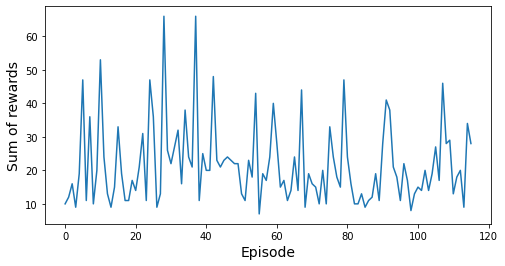

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# This file contains the sum of rewards from a previous successfull training run
rewards_history = np.loadtxt("training_rewards2.txt") + 1

cmap = plt.get_cmap('tab20c')

fig = plt.figure(figsize=(8,5))
plt.axhline([200], ls = 'dashed', c=cmap(9))
plt.text(-50,190, s='Max reward', c=cmap(8))

plt.text(-50,100, s='Exploration\nphase', c=cmap(12))
plt.text(1100,100, s='Exploitation\nphase', c=cmap(12))

plt.plot(rewards_history, c = cmap(4))
plt.xlabel("Episodes")
plt.ylabel("Final reward")

plt.tight_layout()
plt.show()

OSError: ignored

In [20]:
# Set the environment seed for reproducibility 
env.seed(42)

state = env.reset()

frames = []
for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        print("End at step:", step)
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


End at step: 7


In [19]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 41.1 MB/s eta 0:00:00
